# Experimental: Self-Supervised Learning

Our goal will be to teach a neural network to learn how to solve an airfoil optimization problem. This notebook uses a surrogate model of the actual CFD solver for development purposes.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import pathlib
import itertools
import jenn
from scipy.stats import qmc
from jenn.core.cost import Loss

In [3]:
SEED = 123

## Parabolic Test Function

_First, we will test that the process is working for a parabolic test function._

### Training Data

In [4]:
m = 100
lb = -5
ub = 5
x_train = x1 = np.linspace(lb, ub, m).reshape((1, -1)) 
x2 = -1/2 * x1  # optimum given x1
y_train = x1 ** 2 + x2 ** 2 + x1 * x2

### Custom Loss

In [5]:
class CustomLoss(Loss): 
    """Parabola."""

    def denormalize(self, Y_pred: np.ndarray) -> np.ndarray:
        x_norm = self.X 
        y_norm = Y_pred 
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y
        
    def evaluate(self, Y_pred: np.ndarray) -> np.ndarray:
        x, y = self.denormalize(Y_pred)
        return x ** 2 + y ** 2 + x * y

    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        return 2 * y + x

### Training

Training can be done in one line of code. 

In [6]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0], 7, 7, y_train.shape[0]],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-3,
    lambd=1e-4, 
    beta1=0.8,
    beta2=0.7,
    max_iter=2000,
    is_normalize=False,
    is_backtracking=True,
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CustomLoss,
    N1_max=25,
    N2_max=25, 
)

CPU times: user 630 ms, sys: 2.08 ms, total: 632 ms
Wall time: 631 ms


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

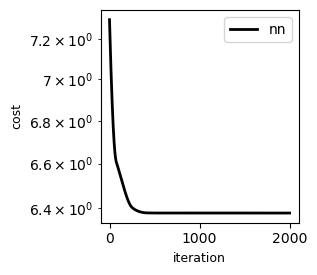

In [7]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

#### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

In [8]:
x1 = x_train
x2 = nn.predict(x_train) 
y_pred = x1 ** 2 + x2 ** 2 + x1 * x2

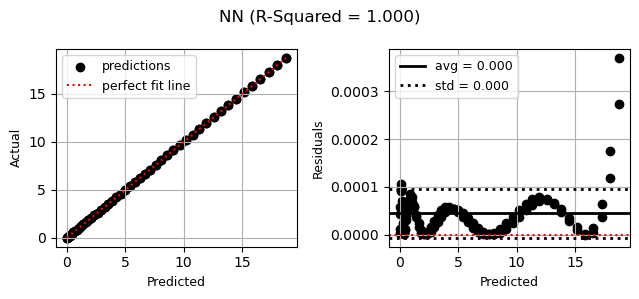

In [9]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train, 
    y_pred=y_pred,
    title="NN"
)

## Airfoil Shape Optimization 

We now test SSL on a small yet representative airfoil shape optimization problem. Given some desired flight condition, we seek to use SSL in order to predict the optimal airfoil shape. 

### Training Data

In [10]:
df = pd.read_csv("DATABASE_OF_OPTIMIZED_SHAPEVARS.csv", index_col=0)

In [11]:
df["doe"] = "train"
df.loc[df.sample(5).index, "doe"] = "test"

In [12]:
df_train = df[df["doe"] == "train"]
df_test = df[df["doe"] == "test"]

In [13]:
x_labels = ["M", "CL"]
y_labels = [f"X{i}" for i in range(14)]

In [14]:
x_train = df_train[x_labels].values.T
y_train = df_train[y_labels].values.T

In [15]:
x_test = df_test[x_labels].values.T
y_test = df_test[y_labels].values.T

In [16]:
n_x = len(x_labels)
n_y = len(y_labels)

<Axes: xlabel='M', ylabel='CL'>

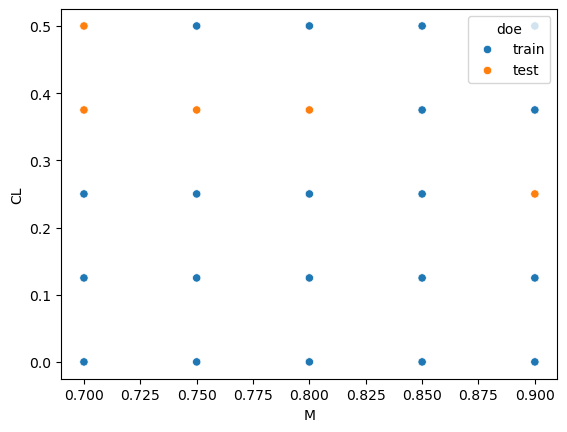

In [17]:
sns.scatterplot(
    data=df, 
    x="M", 
    y="CL", 
    hue="doe", 
)

### CFD Function Call

In [18]:
surrogate_model = jenn.model.NeuralNet(
        layer_sizes=[16, [16] * 5, 1]
    ).load('gnn_parameters_7500.json') 

In [19]:
def cfd_model(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]: 
    """Evaluate CFD surrogate model. 

    :param x: array of shape (2, m) containing [M, CL]
    :param y: array of shape (14, m) containing shape variables 
    :returns: CD, dCDdy 
    """
    CD, CD_partials = surrogate_model.evaluate(np.concatenate([x, y], axis=0)) 
    return CD, CD_partials[:, 2:, :]

### Custom Loss

_We'll use a surrogate of the model for illustration but, in practice, one would use the actual CFD model._

In [20]:
def transform(loss: np.ndarray, loss_partials: np.ndarray, multiplier: float = 1e4, is_log: bool = False): 
    if is_log:
        loss = np.log(1 + multiplier * np.abs(loss))
        loss_partials = multiplier * loss_partials / (1 + multiplier * np.abs(loss))
    else:
        loss = multiplier * 0.5 * loss ** 2
        loss_partials = multiplier * loss_partials * loss
    return loss, loss_partials

In [21]:
class CFDLoss(Loss): 
    """Minimize drag."""

    def denormalize(self, x_norm: np.ndarray, y_norm: np.ndarray) -> np.ndarray:
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y

    def normalize(self, partials: np.ndarray) -> np.ndarray:
        return partials * self.data.y_scale

    def exterior_penalty(self, y: np.ndarray, lb: float = -0.01, ub: float = 0.01, r_p: float = 1e3): 
        """Use exterior penalty to account for bound constraints."""
        n, m = y.shape 
        ymax = np.maximum(0, (y - ub)) / (ub - lb) 
        ymin = np.minimum(0, (y - lb)) / (ub - lb) 
        value = r_p * 0.5 * (ymin ** 2 + ymax ** 2)
        partials = r_p * (ymin + ymax) / (ub - lb)
        return value, partials.reshape((1, n, m))
        
    def evaluate(self, Y_pred: np.ndarray, is_verbose: bool = False) -> np.ndarray:
        """Compute drag for each airfoil shape."""
        x, y = self.denormalize(self.X, Y_pred)
        drag, drag_partials = cfd_model(x, y) 
        loss, loss_partials = transform(drag, drag_partials)
        penalty, penalty_partials = self.exterior_penalty(y)
        
        if is_verbose: 
            print()
            for i in range(x.shape[-1]): 
                print(f"CASE: {i:4n} | M = {x[0, i].round(4): 6.4f} | Cl = {x[1, i].round(4): 6.4f} | Cd = {drag[0, i].round(4): 6.4f} | Loss = {loss[0, i].round(4): 8.4f} | penalty = {penalty[0, i].round(2): 6.2f}")
            print()
            
        return loss + penalty # this does a broadcasting operation that has for effect to weigh large drag more heavily
    
    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(self.X, Y_pred)
        drag, drag_partials = cfd_model(x, y) 
        loss, loss_partials = transform(drag, drag_partials)
        penalty, penalty_partials = self.exterior_penalty(y)
        partials = loss_partials + penalty_partials
        return self.normalize(partials)

### Training

In [22]:
n_x, m = x_train.shape 
n_y, _ = y_train.shape  # y_train not needed in SSL

#### Naive

In [23]:
naive = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [25] * 4 + [y_train.shape[0]]
).fit( 
    x=x_train, 
    y=y_train, 
    alpha=1e-2,
    lambd=1e-6,
    beta1=0.9,
    beta2=0.99,
    max_count=7,
    max_iter=2000,
    is_warmstart=False, 
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    epsilon_absolute=1e-12,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-12,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=5,
    N2_max=5,
    tol=1e-12
)

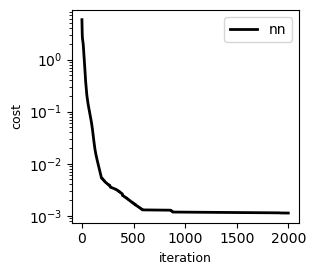

In [24]:
jenn.utils.plot.convergence(histories=[naive.history], legend=["nn"])

#### SSL

In [25]:
%%time
ssl = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [25] * 4 + [y_train.shape[0]]
).fit( 
    x=x_train, 
    y=y_train, 
    alpha=1e-2,
    lambd=1e-6,
    beta1=0.9,
    beta2=0.99,
    max_count=7,
    max_iter=2000,
    is_warmstart=False, 
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CFDLoss, 
    epsilon_absolute=1e-12,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-12,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=5,
    N2_max=5,
    tol=1e-12
)

CPU times: user 79.5 ms, sys: 1.42 ms, total: 80.9 ms
Wall time: 80 ms


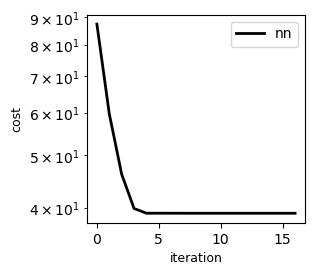

In [26]:
jenn.utils.plot.convergence(histories=[ssl.history], legend=["nn"])

In [27]:
ssl.predict(np.array([[0.7, 0.8, 0.9], [0.25, 0.375, 0.5]])) # visually inspect to ensure airfoil shapes are different across flight regimes

array([[ 3.77701567e-03, -4.45113150e-03, -9.00896860e-03],
       [-6.56576381e-04, -7.64325355e-03, -1.07284520e-02],
       [ 1.80351495e-03, -9.01310006e-03, -1.35782212e-02],
       [ 2.37594571e-04, -5.38252146e-03, -7.78906825e-03],
       [-1.34878351e-03, -3.47625193e-03, -2.41287544e-03],
       [ 8.10929001e-04, -2.47102336e-03, -2.64031846e-03],
       [ 8.25503617e-05, -4.94045030e-03, -5.19798521e-03],
       [-3.50489717e-03, -2.15046990e-03, -1.48456712e-03],
       [ 4.64474247e-04, -8.31072401e-03, -1.39994815e-02],
       [ 2.28923944e-04, -6.58966334e-03, -1.16160151e-02],
       [ 1.80663020e-03, -3.19505310e-03, -6.91436576e-03],
       [ 3.41083778e-03,  1.86288592e-03, -1.45415235e-03],
       [ 5.28475657e-03,  2.36225400e-03, -2.82227284e-03],
       [ 1.72549355e-03,  1.55950622e-03,  1.70083720e-03]])

### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

#### SSL

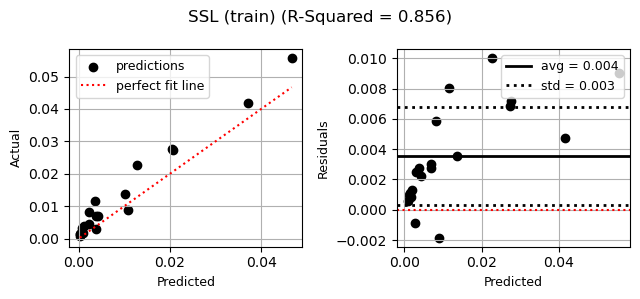

In [28]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=ssl.predict(x_train))[0],
    title="SSL (train)", 
    percent_residuals=False
)

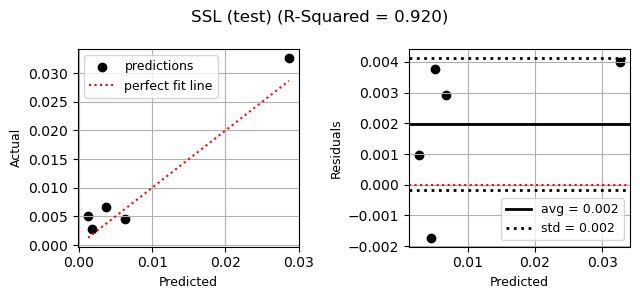

In [29]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_test["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_test, y=ssl.predict(x_test))[0],
    title="SSL (test)", 
    percent_residuals=False
)

### Naive

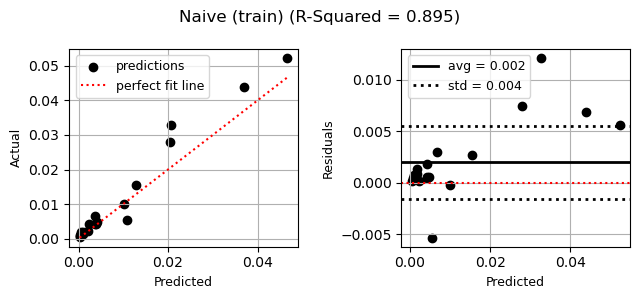

In [36]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=naive.predict(x_train))[0],
    title="Naive (train)", 
    percent_residuals=False
)

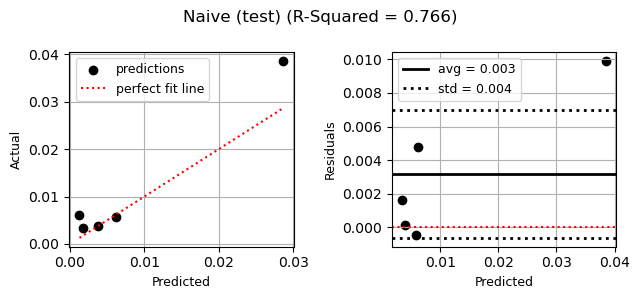

In [37]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_test["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_test, y=naive.predict(x_test))[0],
    title="Naive (test)", 
    percent_residuals=False
)

### CFD Surrogate

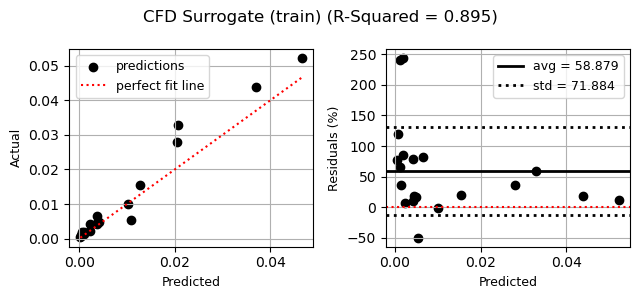

In [41]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=y_train)[0],
    title="CFD Surrogate (train)", 
    percent_residuals=True
)

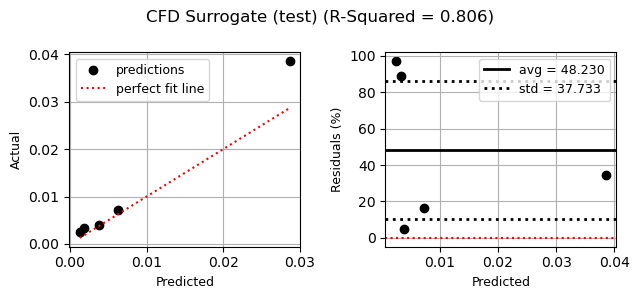

In [40]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_test["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_test, y=y_test)[0],
    title="CFD Surrogate (test)", 
    percent_residuals=True
)

#### Shape Variables

##### SSL

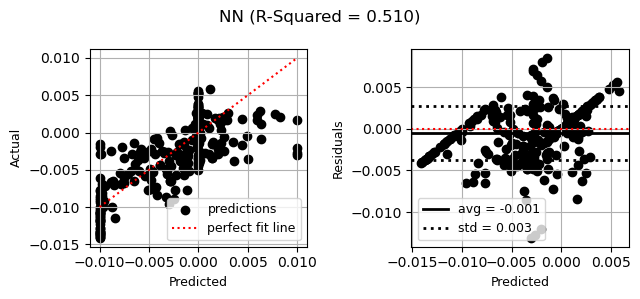

In [34]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train.ravel(),
    y_pred=ssl.predict(x_train).ravel(),
    title="NN", 
    percent_residuals=False
)

##### Naive

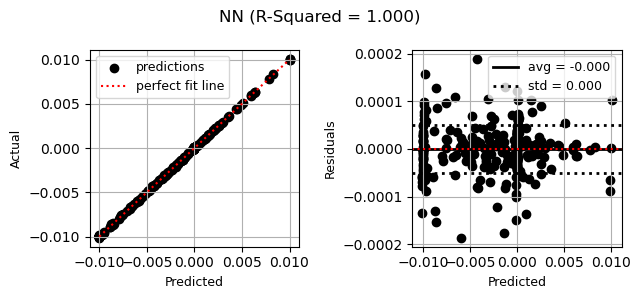

In [35]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train.ravel(),
    y_pred=naive.predict(x_train).ravel(),
    title="NN", 
    percent_residuals=False
)

## Conclusions

SSL and the naive approach performed similarly in terms of prediction accuracy; albeit the naive approach was a bit better. However, SSL was significantly faster to train, all else being equal. The amount of training / test data was rather small and a surrogate model of CFD was used, both of which introduce uncertainty that prevents a firm conclusion about one approach being better than the other. All we can say is that one faster.  